In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
# Carga de archivos

df_clientes = pd.read_csv(r"data/clean/clientes.csv")
df_productos = pd.read_csv(r"data/clean/productos.csv")
df_ventas = pd.read_csv(r"data/clean/ventas.csv")
df_detalle = pd.read_csv(r"data/clean/detalle_ventas.csv")


In [17]:
# Parsear fechas
df_ventas['fecha'] = pd.to_datetime(df_ventas['fecha'])
df_clientes['fecha_alta'] = pd.to_datetime(df_clientes['fecha_alta'])

# Fecha de referencia (última fecha en datos)
FECHA_REF = df_ventas['fecha'].max()
print(f"Fecha maxima: {FECHA_REF}")
print(f"Total clientes: {len(df_clientes)}")
print(f"Total ventas: {len(df_ventas)}")
print(f"Total productos: {len(df_productos)}")
print(f"Total líneas detalle: {len(df_detalle)}")

Fecha maxima: 2024-10-31 21:49:00
Total clientes: 1531
Total ventas: 113882
Total productos: 100
Total líneas detalle: 279528


In [18]:
# Join detalle con productos para categorías
df_full = df_detalle.merge(
    df_productos[['id_producto', 'categoria']], 
    on='id_producto',
    how='left'
)

# Join con ventas para fechas
df_full = df_full.merge(
    df_ventas[['id_venta', 'id_cliente', 'fecha']], 
    on='id_venta',
    how='left'
)

print(f"Dataset completo: {len(df_full)} registros")

Dataset completo: 279528 registros


#### Feature Engineering

In [19]:
# 1. FEATURES RFM

# Recency: días desde última compra
recency = df_full.groupby('id_cliente')['fecha'].max().reset_index()
recency['recency_dias'] = (FECHA_REF - recency['fecha']).dt.days
recency = recency[['id_cliente', 'recency_dias']]

# Frequency: número de compras únicas
frequency = df_ventas.groupby('id_cliente')['id_venta'].nunique().reset_index()
frequency.columns = ['id_cliente', 'frequency']

# # Monetary: gasto total
monetary = df_full.groupby('id_cliente')['importe'].sum().reset_index()
monetary.columns = ['id_cliente', 'monetary']

# Combinar RFM
features = recency.merge(frequency, on='id_cliente')
features = features.merge(monetary, on='id_cliente')

In [20]:
# 2. FEATURES DE COMPORTAMIENTO POR CATEGORÍA

# Gasto por cliente y categoría
gasto_categoria = df_full.groupby(['id_cliente', 'categoria'])['importe'].sum().reset_index()

# Pivot: categorías como columnas
gasto_pivot = gasto_categoria.pivot(
    index='id_cliente', 
    columns='categoria', 
    values='importe'
).fillna(0)

# Renombrar columnas
gasto_pivot.columns = [f'gasto_{col.lower().replace(" ", "_").replace("y", "").replace("__", "_")}' 
                       for col in gasto_pivot.columns]

# Calcular PORCENTAJES (más importante que valores absolutos)
gasto_total = gasto_pivot.sum(axis=1)
gasto_pct = gasto_pivot.div(gasto_total, axis=0) * 100
gasto_pct.columns = [col.replace('gasto_', 'pct_') for col in gasto_pct.columns]

# Merge con features
features = features.merge(gasto_pct, left_on='id_cliente', right_index=True, how='left')

In [21]:
# 3. FEATURES DE DIVERSIDAD
categoria_cols = [col for col in features.columns if col.startswith('pct_')]

# Diversidad de categorías (Shannon entropy)
def shannon_entropy(row):
    """Calcula entropía de Shannon para diversidad de categorías"""
    from scipy.stats import entropy
    probs = row[categoria_cols].values
    probs = probs[probs > 0]
    return entropy(probs)

features['diversidad_categorias'] = features.apply(shannon_entropy, axis=1)

In [22]:

# 3. FEATURES DE DIVERSIDAD
# Productos únicos comprados
productos_unicos = df_full.groupby('id_cliente')['id_producto'].nunique().reset_index()
productos_unicos.columns = ['id_cliente', 'productos_unicos']

# Productos por transacción (promedio)
productos_por_tx = df_full.groupby(['id_cliente', 'id_venta'])['id_producto'].count().reset_index()
productos_por_tx = productos_por_tx.groupby('id_cliente')['id_producto'].mean().reset_index()
productos_por_tx.columns = ['id_cliente', 'productos_por_transaccion']

# Merge
features = features.merge(productos_unicos, on='id_cliente', how='left')
features = features.merge(productos_por_tx, on='id_cliente', how='left')

In [23]:
# DEFINIR FEATURE SETS PARA CLUSTERING

# Excluir id_cliente
X_all = features.drop('id_cliente', axis=1)

In [24]:
X_all.columns

Index(['recency_dias', 'frequency', 'monetary', 'pct_bebidas',
       'pct_bebidas_alcohólicas', 'pct_congelados', 'pct_despensa',
       'pct_limpieza_cuidado', 'pct_lácteos_panadería', 'pct_snacks_golosinas',
       'diversidad_categorias', 'productos_unicos',
       'productos_por_transaccion'],
      dtype='object')

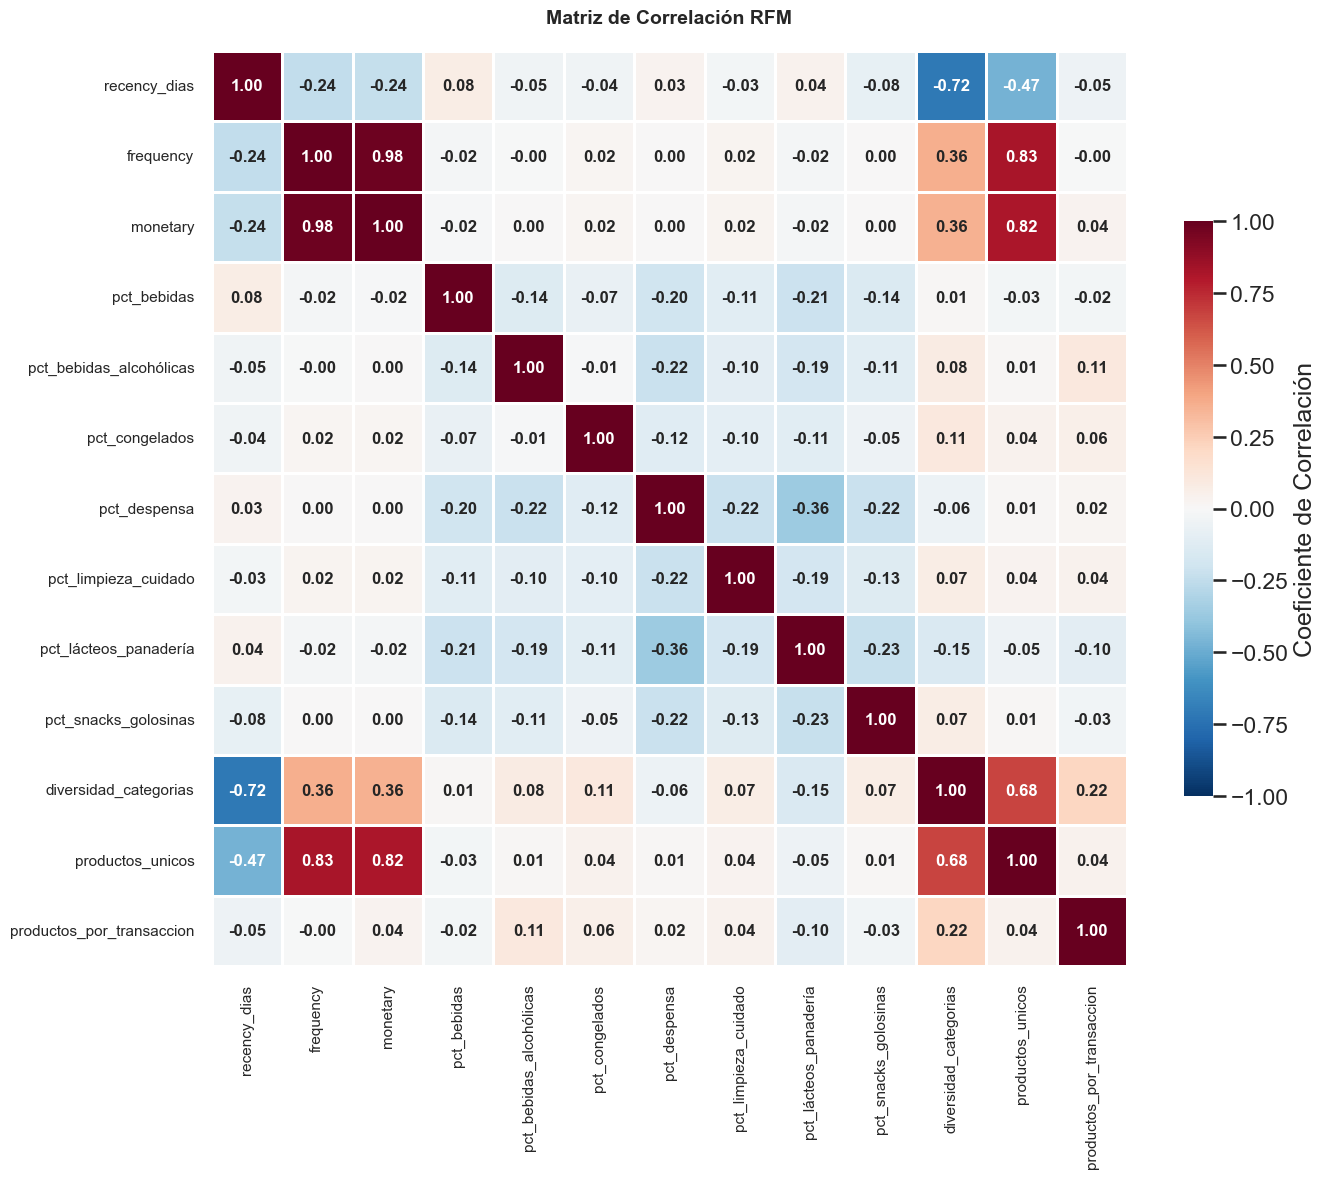

In [25]:
corr_matrix = X_all.corr()

# Visualización
fig, ax = plt.subplots(figsize=(14, 12))

# Visualizar la matriz con un mapa de calor más compacto
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', fmt=".2f",
            linewidths=1, vmin=-1, vmax=1, square=True,
            cbar_kws={'shrink': 0.6, 'label': 'Coeficiente de Correlación'},
            annot_kws={'fontsize': 12, 'fontweight': 'bold'})

plt.title('Matriz de Correlación RFM', fontsize=14, fontweight='bold', pad=20)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()

In [26]:

# Identificar correlaciones altas
print("\n🔍 Features con correlación alta (|r| > 0.5):")
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr.append({
                'feature_1': corr_matrix.columns[i],
                'feature_2': corr_matrix.columns[j],
                'correlation': corr_matrix.iloc[i, j]
            })

if high_corr:
    df_high_corr = pd.DataFrame(high_corr).sort_values('correlation', 
                                                        key=abs, 
                                                        ascending=False)
    print(df_high_corr.to_string(index=False))
else:
    print("   ✓ No hay correlaciones altas detectadas")



🔍 Features con correlación alta (|r| > 0.5):
   feature_1             feature_2  correlation
   frequency              monetary     0.982379
   frequency      productos_unicos     0.825490
    monetary      productos_unicos     0.815908
recency_dias diversidad_categorias    -0.717020


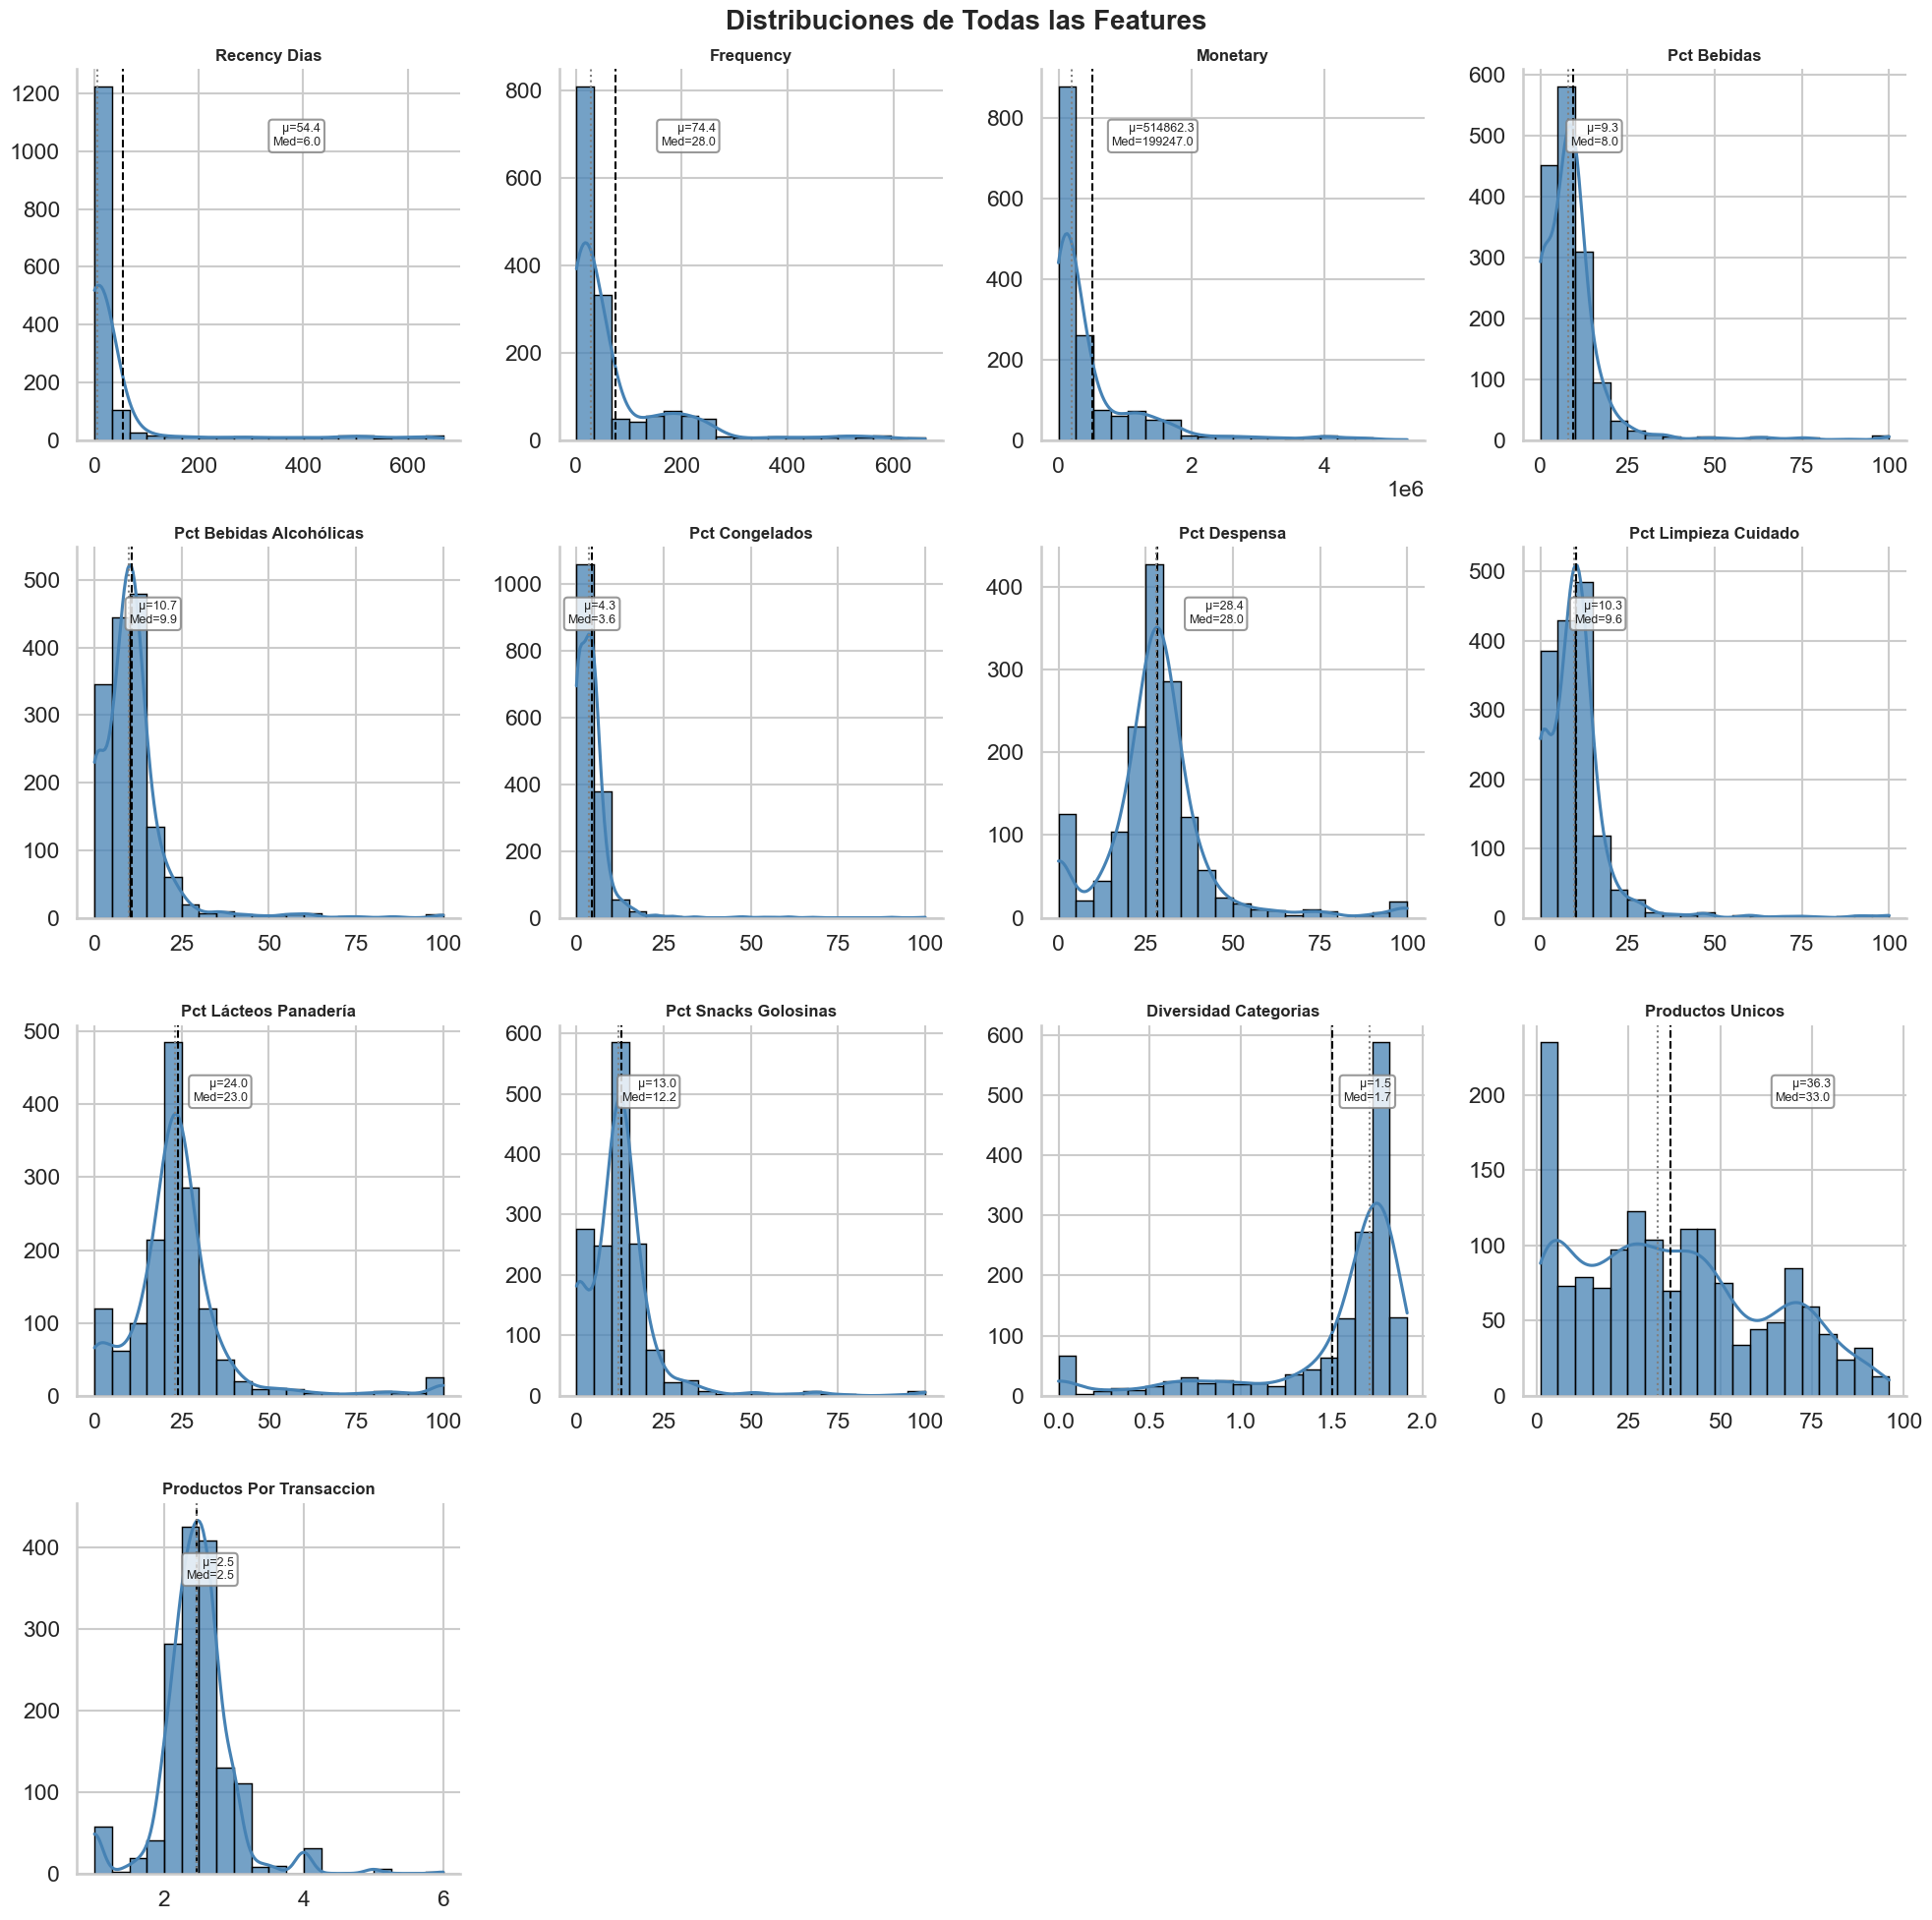

In [27]:
sns.set_style("whitegrid")
sns.set_context("talk")

# Crear una grilla más grande para acomodar 14 features
n_features = len(X_all.columns)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols  # Redondear hacia arriba

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
fig.suptitle('Distribuciones de Todas las Features', fontsize=20, weight='bold')
fig.subplots_adjust(top=0.95, wspace=0.3, hspace=0.4)

# Aplanar axes para facilitar iteración
axes = axes.flatten()

# Helper para dibujar media/mediana
def _annotate_stats(ax, data, xpos='right'):
    mean = data.mean()
    median = data.median()
    ymax = ax.get_ylim()[1]
    ax.axvline(mean, color='k', linestyle='--', linewidth=1.5)
    ax.axvline(median, color='gray', linestyle=':', linewidth=1.5)
    
    # Posición del texto
    x_text = data.quantile(0.95) if xpos == 'right' else data.quantile(0.05)
    ax.text(x_text, ymax*0.82, f"μ={mean:.1f}\nMed={median:.1f}", 
            ha='right' if xpos == 'right' else 'left', va='center',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8), 
            fontsize=9)

# Crear histogramas para cada feature
for idx, col in enumerate(X_all.columns):
    ax = axes[idx]
    
    # Histograma
    sns.histplot(X_all[col], bins=20, kde=True, 
                color='steelblue', alpha=0.75, edgecolor='k', ax=ax)
    
    # Títulos y etiquetas
    ax.set_title(col.replace('_', ' ').title(), fontsize=12, weight='semibold')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # Estadísticas
    _annotate_stats(ax, X_all[col])
    sns.despine(ax=ax)

# Ocultar ejes sobrantes si los hay
for idx in range(n_features, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

In [28]:
stats = pd.DataFrame({
    'feature': X_all.columns,
    'skewness': X_all.skew(),
    'kurtosis': X_all.kurtosis(),
    'min': X_all.min(),
    'max': X_all.max(),
    'zeros_%': (X_all == 0).sum() / len(X_all) * 100
}).round(3)

print(stats.to_string(index=False))

                  feature  skewness  kurtosis   min         max  zeros_%
             recency_dias     3.135     8.961   0.0     668.000   13.390
                frequency     2.607     7.536   1.0     660.000    0.000
                 monetary     2.785     8.877 272.0 5242937.000    0.000
              pct_bebidas     4.501    27.841   0.0     100.000   19.464
  pct_bebidas_alcohólicas     3.951    24.648   0.0     100.000   13.782
           pct_congelados     7.293    80.670   0.0     100.000   19.987
             pct_despensa     1.556     5.994   0.0     100.000    7.903
     pct_limpieza_cuidado     4.229    26.932   0.0     100.000   16.917
    pct_lácteos_panadería     2.447     9.791   0.0     100.000    5.291
     pct_snacks_golosinas     3.625    20.890   0.0     100.000   12.606
    diversidad_categorias    -1.962     2.866   0.0       1.917    4.311
         productos_unicos     0.371    -0.873   1.0      96.000    0.000
productos_por_transaccion     0.613     6.600   1.0

In [29]:
import pandas as pd

# Calcular outliers con regla 1.5*IQR para cada columna
outlier_stats = []

for col in X_all.columns:
    Q1 = X_all[col].quantile(0.25)
    Q3 = X_all[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_mask = (X_all[col] < lower_bound) | (X_all[col] > upper_bound)
    n_outliers = outliers_mask.sum()
    pct_outliers = (n_outliers / len(X_all)) * 100
    
    outlier_stats.append({
        'feature': col,
        'n_outliers': n_outliers,
        'pct_outliers': round(pct_outliers, 2),
        'lower_bound': round(lower_bound, 2),
        'upper_bound': round(upper_bound, 2)
    })

df_outliers = pd.DataFrame(outlier_stats).sort_values('pct_outliers', ascending=False)
print(df_outliers.to_string(index=False))

                  feature  n_outliers  pct_outliers  lower_bound  upper_bound
                frequency         263         17.18       -78.00       154.00
    diversidad_categorias         244         15.94         1.08         2.20
             recency_dias         224         14.63       -29.50        54.50
             pct_despensa         219         14.30         6.05        49.22
    pct_lácteos_panadería         206         13.46         4.50        40.65
                 monetary         196         12.80   -674130.25   1275079.75
productos_por_transaccion         119          7.77         1.57         3.34
     pct_snacks_golosinas          86          5.62        -3.52        26.82
              pct_bebidas          78          5.09        -7.45        22.14
  pct_bebidas_alcohólicas          75          4.90        -5.16        23.81
     pct_limpieza_cuidado          74          4.83        -6.75        24.34
           pct_congelados          66          4.31        -5.87

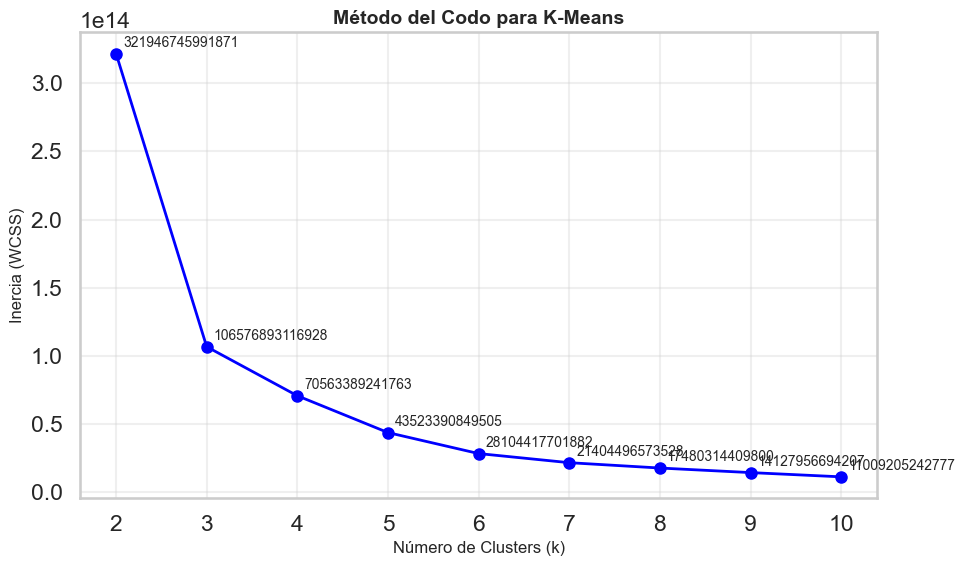

Análisis del Método del Codo:
    k       inertia     reduction
0   2  3.219467e+14  0.000000e+00
1   3  1.065769e+14  2.153699e+14
2   4  7.056339e+13  3.601350e+13
3   5  4.352339e+13  2.704000e+13
4   6  2.810442e+13  1.541897e+13
5   7  2.140450e+13  6.699921e+12
6   8  1.748031e+13  3.924182e+12
7   9  1.412796e+13  3.352358e+12
8  10  1.100921e+13  3.118751e+12


In [30]:
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

# Método del codo
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_all)
    inertias.append(kmeans.inertia_)

# Gráfico del codo
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.title('Método del Codo para K-Means', fontsize=14, fontweight='bold')
plt.xlabel('Número de Clusters (k)', fontsize=12)
plt.ylabel('Inercia (WCSS)', fontsize=12)
plt.grid(True, alpha=0.3)

# Añadir valores en cada punto
for i, inertia in enumerate(inertias):
    plt.annotate(f'{inertia:.0f}', 
                xy=(K_range[i], inertia), 
                xytext=(5, 5), 
                textcoords='offset points',
                fontsize=10)

plt.tight_layout()
plt.show()

# Mostrar tabla de resultados
elbow_results = pd.DataFrame({
    'k': K_range,
    'inertia': inertias,
    'reduction': [0] + [inertias[i-1] - inertias[i] for i in range(1, len(inertias))]
})

print("Análisis del Método del Codo:")
print(elbow_results.round(2))

In [31]:
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Clustering
kmeans_no_scale = KMeans(n_clusters=3, random_state=42, n_init='auto')
labels_no_scale = kmeans_no_scale.fit_predict(X_all)

# Reducción dimensional para visualizar (PCA)
pca = PCA(n_components=2, random_state=42)
X_pca_no_scale = pca.fit_transform(X_all)

# Crear dataframe para plotly
df_plot_no_scale = pd.DataFrame({
    'PC1': X_pca_no_scale[:, 0],
    'PC2': X_pca_no_scale[:, 1],
    'Cluster': labels_no_scale.astype(str),
    'Monetary': X_all['monetary'].values,
    'Frequency': X_all['frequency'].values,
    'Recency': X_all['recency_dias'].values
})

# Plot
fig1 = px.scatter(
    df_plot_no_scale,
    x='PC1', y='PC2',
    color='Cluster',
    hover_data=['Monetary', 'Frequency', 'Recency'],
    title=f'+Varianza explicada: {pca.explained_variance_ratio_.sum():.2%}',
    width=800, height=600
)
fig1.show()

c:\Users\Dell\anaconda3\envs\demo\lib\site-packages\plotly\express\_core.py:2065: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


In [32]:
pd.DataFrame(labels_no_scale).value_counts()

0
0    1210
1     265
2      56
Name: count, dtype: int64

In [37]:
X_all.columns

Index(['recency_dias', 'frequency', 'monetary', 'pct_bebidas',
       'pct_bebidas_alcohólicas', 'pct_congelados', 'pct_despensa',
       'pct_limpieza_cuidado', 'pct_lácteos_panadería', 'pct_snacks_golosinas',
       'diversidad_categorias', 'productos_unicos',
       'productos_por_transaccion'],
      dtype='object')

In [53]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# # Create a copy and apply log transformation to monetary
# X_train = X_all.copy()
# X_train['monetary'] = np.log1p(X_train['monetary'])

# # Scale all features except monetary
# features_to_scale = [col for col in X_train.columns if col != 'monetary']
# scaler = StandardScaler()

# # Scale only the selected features
# X_scaled = X_train.copy()
# X_scaled[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
# X_train = X_scaled

## Second method: Not log transform monetary
# Scale all features except monetary
scaler = StandardScaler()

# Scale only the selected features
X_scaled = scaler.fit_transform(X_all)
X_train = pd.DataFrame(X_scaled, columns=X_all.columns)

In [54]:
stats = pd.DataFrame({
    'feature': X_train.columns,
    'skewness': X_train.skew(),
    'kurtosis': X_train.kurtosis(),
    'min': X_train.min(),
    'max': X_train.max(),
    'zeros_%': (X_train == 0).sum() / len(X_train) * 100
}).round(3)

print(stats.to_string(index=False))

                  feature  skewness  kurtosis    min    max  zeros_%
             recency_dias     3.135     8.961 -0.407  4.587      0.0
                frequency     2.607     7.536 -0.651  5.192      0.0
                 monetary     2.785     8.877 -0.641  5.892      0.0
              pct_bebidas     4.501    27.841 -0.822  8.021      0.0
  pct_bebidas_alcohólicas     3.951    24.648 -1.018  8.474      0.0
           pct_congelados     7.293    80.670 -0.682 15.161      0.0
             pct_despensa     1.556     5.994 -1.779  4.485      0.0
     pct_limpieza_cuidado     4.229    26.932 -0.948  8.242      0.0
    pct_lácteos_panadería     2.447     9.791 -1.547  4.896      0.0
     pct_snacks_golosinas     3.625    20.890 -1.115  7.490      0.0
    diversidad_categorias    -1.962     2.866 -3.154  0.867      0.0
         productos_unicos     0.371    -0.873 -1.395  2.357      0.0
productos_por_transaccion     0.613     6.600 -2.813  6.831      0.0


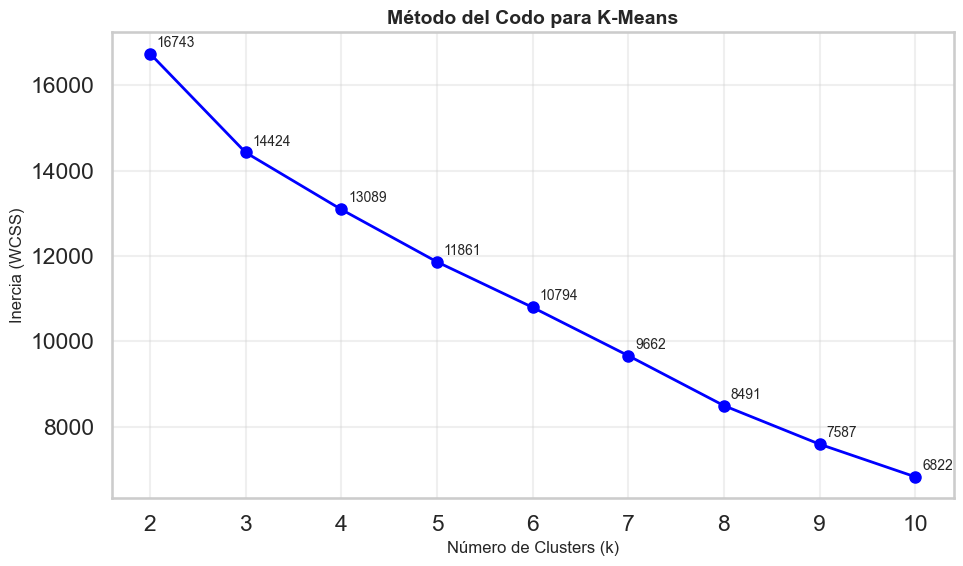

Análisis del Método del Codo:
    k   inertia  reduction
0   2  16743.47       0.00
1   3  14424.00    2319.47
2   4  13088.77    1335.23
3   5  11860.75    1228.02
4   6  10793.91    1066.84
5   7   9661.77    1132.14
6   8   8490.62    1171.15
7   9   7587.11     903.50
8  10   6821.91     765.20


In [55]:
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

# Método del codo
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train)
    inertias.append(kmeans.inertia_)

# Gráfico del codo
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.title('Método del Codo para K-Means', fontsize=14, fontweight='bold')
plt.xlabel('Número de Clusters (k)', fontsize=12)
plt.ylabel('Inercia (WCSS)', fontsize=12)
plt.grid(True, alpha=0.3)

# Añadir valores en cada punto
for i, inertia in enumerate(inertias):
    plt.annotate(f'{inertia:.0f}', 
                xy=(K_range[i], inertia), 
                xytext=(5, 5), 
                textcoords='offset points',
                fontsize=10)

plt.tight_layout()
plt.show()

# Mostrar tabla de resultados
elbow_results = pd.DataFrame({
    'k': K_range,
    'inertia': inertias,
    'reduction': [0] + [inertias[i-1] - inertias[i] for i in range(1, len(inertias))]
})

print("Análisis del Método del Codo:")
print(elbow_results.round(2))

In [58]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

results = []

for k in range(3, 15):
    # K-means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_km = kmeans.fit_predict(X_train)
    
    # Hierarchical
    hier = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels_hier = hier.fit_predict(X_train)
    
    # Métricas
    for name, labels in [('kmeans', labels_km), ('hierarchical', labels_hier)]:
        results.append({
            'method': name,
            'k': k,
            'silhouette': silhouette_score(X_train, labels),
            'calinski': calinski_harabasz_score(X_train, labels),
            'davies': davies_bouldin_score(X_train, labels),
            'inertia_km': kmeans.inertia_ if name == 'kmeans' else np.nan
        })

df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))

      method  k  silhouette   calinski   davies   inertia_km
      kmeans  3    0.265094 290.208466 1.828750 14424.004843
hierarchical  3    0.258005 266.275487 2.132693          NaN
      kmeans  4    0.287732 264.993561 1.794087 13088.774266
hierarchical  4    0.274628 246.819737 1.963920          NaN
      kmeans  5    0.311933 258.678115 1.835446 11860.753007
hierarchical  5    0.287917 243.580596 1.897354          NaN
      kmeans  6    0.308987 257.392369 1.327684 10793.914238
hierarchical  6    0.297932 245.917420 1.499291          NaN
      kmeans  7    0.334174 269.233386 1.264511  9661.772617
hierarchical  7    0.310212 256.823967 1.387113          NaN
      kmeans  8    0.348526 292.441310 1.145038  8490.619576
hierarchical  8    0.321426 272.733705 1.212023          NaN
      kmeans  9    0.356935 308.825853 0.915704  7587.114713
hierarchical  9    0.328652 287.344638 0.943979          NaN
      kmeans 10    0.287882 324.059167 0.895898  6821.913522
hierarchical 10    0.271

In [59]:
# Clustering
X_all = X_all.drop('cluster', axis=1, errors='ignore')
kmeans_scaled = KMeans(n_clusters=9, random_state=42, n_init='auto')
labels_scaled = kmeans_scaled.fit_predict(X_train)

# PCA
pca2 = PCA(n_components=2, random_state=42)
X_pca_scaled = pca2.fit_transform(X_train)

# Dataframe
df_plot_scaled = pd.DataFrame({
    'PC1': X_pca_scaled[:, 0],
    'PC2': X_pca_scaled[:, 1],
    'Cluster': labels_scaled.astype(str),
    'Monetary': X_all['monetary'].values,
    'Frequency': X_all['frequency'].values,
    'Recency': X_all['recency_dias'].values,
    'pct_despensa': X_all['pct_despensa'].values,
    'pct_bebidas_alcoh': X_all['pct_bebidas_alcohólicas'].values
})

# Plot
fig2 = px.scatter(
    df_plot_scaled,
    x='PC1', y='PC2',
    color='Cluster',
    hover_data=['Monetary', 'Frequency', 'pct_despensa', 'pct_bebidas_alcoh'],
    title=f'Varianza explicada: {pca2.explained_variance_ratio_.sum():.2%}',
    width=800, height=600
)
fig2.show()

c:\Users\Dell\anaconda3\envs\demo\lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [60]:
features['cluster'] = labels_scaled
features.groupby('cluster').mean().round(2)

,id_cliente,recency_dias,frequency,monetary,pct_bebidas,pct_bebidas_alcohólicas,pct_congelados,pct_despensa,pct_limpieza_cuidado,pct_lácteos_panadería,pct_snacks_golosinas,diversidad_categorias,productos_unicos,productos_por_transaccion
cluster,,,,,,,,,,,,,,
0,854.56,181.40,2.58,16951.82,2.68,4.51,13.87,10.79,3.38,10.28,54.50,0.80,4.82,2.30
1,820.85,218.41,1.67,12523.52,1.60,2.40,0.41,8.34,71.51,10.88,4.86,0.66,3.70,2.46
2,756.20,14.99,31.62,217150.94,9.30,10.73,4.34,28.58,10.23,23.91,12.90,1.66,31.75,2.48
3,780.98,1.34,499.16,3553900.56,9.27,10.57,4.54,28.55,10.68,23.48,12.90,1.79,88.66,2.49
4,726.40,289.77,1.17,5930.23,0.71,0.96,1.63,3.90,1.28,89.73,1.79,0.25,2.28,1.97
5,688.77,318.03,1.61,11240.06,71.68,2.89,0.78,10.50,3.41,8.05,2.69,0.65,3.35,2.42
6,890.70,216.68,1.68,13079.14,0.36,60.47,5.22,10.73,4.85,13.69,4.68,0.82,4.16,2.89
7,737.04,309.54,1.26,9326.85,1.85,2.54,0.39,78.89,2.49,10.38,3.46,0.49,2.86,2.44
8,779.69,2.30,188.50,1289227.41,8.82,10.68,4.52,28.32,10.86,23.77,13.03,1.78,70.22,2.45


In [61]:
features.groupby('cluster')['cluster'].count()

cluster
0     50
1     27
2    920
3     61
4     47
5     31
6     37
7     72
8    286
Name: cluster, dtype: int64

In [62]:
df_full = df_full.merge(
    features[['id_cliente', 'cluster']],
    on='id_cliente',
    how='left'
)

In [66]:
# Calcular umbrales desde los datos - más granulares
umbral_inactivo = features['recency_dias'].quantile(0.75)  # Q75 = inactivo
umbral_activo = features['recency_dias'].quantile(0.25)     # Q25 = muy activo

umbral_vip_top = features['frequency'].quantile(0.90)       # Q90 = VIP Premium
umbral_vip = features['frequency'].quantile(0.75)           # Q75 = VIP
umbral_frecuente = features['frequency'].quantile(0.50)     # Q50 = Frecuente

umbral_alto_valor = features['monetary'].quantile(0.75)     # Q75 = alto valor
umbral_medio_valor = features['monetary'].quantile(0.50)    # Q50 = medio valor

print(f"Umbrales calculados:")
print(f"\n📅 RECENCY:")
print(f"  Inactivo (Q75): recency > {umbral_inactivo:.0f} días")
print(f"  Activo (Q25): recency < {umbral_activo:.0f} días")
print(f"\n🔄 FREQUENCY:")
print(f"  VIP Premium (Q90): frequency > {umbral_vip_top:.0f} compras")
print(f"  VIP (Q75): frequency > {umbral_vip:.0f} compras")
print(f"  Frecuente (Q50): frequency > {umbral_frecuente:.0f} compras")
print(f"\n💰 MONETARY:")
print(f"  Alto Valor (Q75): monetary > ${umbral_alto_valor:.2f}")
print(f"  Medio Valor (Q50): monetary > ${umbral_medio_valor:.2f}")

# Calcular perfiles completos
profiles = features.groupby('cluster').agg({
    'recency_dias': 'mean',
    'frequency': 'mean',
    'monetary': 'mean',
    'pct_despensa': 'mean',
    'pct_bebidas_alcohólicas': 'mean',
    'pct_lácteos_panadería': 'mean',
    'pct_limpieza_cuidado': 'mean',
    'pct_snacks_golosinas': 'mean',
    'pct_bebidas': 'mean',
    'pct_congelados': 'mean'
})

# Función mejorada para etiquetar con criterios más específicos
def generar_etiqueta_mejorada(row):
    """
    Genera etiquetas descriptivas basadas en RFM y categorías preferidas.
    Jerarquía: Nivel de Valor > Frecuencia > Estado de Actividad > Categoría
    """
    
    # 1. NIVEL DE VALOR (basado en Monetary + Frequency)
    if row['monetary'] > umbral_alto_valor and row['frequency'] > umbral_vip_top:
        nivel = "VIP Premium"
    elif row['frequency'] > umbral_vip or row['monetary'] > umbral_alto_valor:
        nivel = "VIP"
    elif row['frequency'] > umbral_frecuente:
        nivel = "Habitual"
    else:
        nivel = "Ocasional"
    
    # 2. ESTADO DE ACTIVIDAD
    if row['recency_dias'] > umbral_inactivo:
        estado = "Inactivo"
    elif row['recency_dias'] < umbral_activo:
        estado = "Activo"
    else:
        estado = "Moderado"
    
    # 3. CATEGORÍA DOMINANTE
    categorias = {
        'Despensa': row['pct_despensa'],
        'Lácteos': row['pct_lácteos_panadería'],
        'Bebidas': row['pct_bebidas'],
        'Snacks': row['pct_snacks_golosinas'],
        'Limpieza': row['pct_limpieza_cuidado'],
        'Alcohol': row['pct_bebidas_alcohólicas'],
        'Congelados': row['pct_congelados']
    }
    
    cat_dominante = max(categorias, key=categorias.get)
    pct_dominante = categorias[cat_dominante]
    
    # 4. CONSTRUIR ETIQUETA COMPUESTA
    # Para clientes inactivos, priorizar el estado
    if estado == "Inactivo":
        if pct_dominante > 35:
            return f"{nivel} {estado} ({cat_dominante})"
        else:
            return f"{nivel} {estado}"
    
    # Para clientes activos, priorizar el nivel de valor
    else:
        if pct_dominante > 35:
            return f"{nivel} {estado} ({cat_dominante})"
        else:
            return f"{nivel} {estado}"

# Generar y aplicar etiquetas mejoradas
etiquetas = {}
for cluster_id, row in profiles.iterrows():
    etiquetas[cluster_id] = generar_etiqueta_mejorada(row)

features['cluster_nombre'] = features['cluster'].map(etiquetas)

# Mostrar resultados con métricas detalladas
print("\n" + "="*80)
print("📊 ETIQUETAS GENERADAS CON MÉTRICAS")
print("="*80)
for cluster_id in sorted(profiles.index):
    row = profiles.loc[cluster_id]
    nombre = etiquetas[cluster_id]
    n_clientes = (features['cluster'] == cluster_id).sum()
    
    print(f"\n🏷️  Cluster {cluster_id}: {nombre}")
    print(f"    👥 Clientes: {n_clientes}")
    print(f"    📅 Recency: {row['recency_dias']:.1f} días | 🔄 Frequency: {row['frequency']:.1f} | 💰 Monetary: ${row['monetary']:.2f}")
    
    # Mostrar top 2 categorías
    cats = {
        'Despensa': row['pct_despensa'],
        'Lácteos': row['pct_lácteos_panadería'],
        'Bebidas': row['pct_bebidas'],
        'Snacks': row['pct_snacks_golosinas'],
        'Limpieza': row['pct_limpieza_cuidado'],
        'Alcohol': row['pct_bebidas_alcohólicas'],
        'Congelados': row['pct_congelados']
    }
    top2 = sorted(cats.items(), key=lambda x: x[1], reverse=True)[:2]
    print(f"    🛒 Top categorías: {top2[0][0]} ({top2[0][1]:.1f}%), {top2[1][0]} ({top2[1][1]:.1f}%)")


Umbrales calculados:

📅 RECENCY:
  Inactivo (Q75): recency > 23 días
  Activo (Q25): recency < 2 días

🔄 FREQUENCY:
  VIP Premium (Q90): frequency > 213 compras
  VIP (Q75): frequency > 67 compras
  Frecuente (Q50): frequency > 28 compras

💰 MONETARY:
  Alto Valor (Q75): monetary > $544126.00
  Medio Valor (Q50): monetary > $199247.00

📊 ETIQUETAS GENERADAS CON MÉTRICAS

🏷️  Cluster 0: Ocasional Inactivo (Snacks)
    👥 Clientes: 50
    📅 Recency: 181.4 días | 🔄 Frequency: 2.6 | 💰 Monetary: $16951.82
    🛒 Top categorías: Snacks (54.5%), Congelados (13.9%)

🏷️  Cluster 1: Ocasional Inactivo (Limpieza)
    👥 Clientes: 27
    📅 Recency: 218.4 días | 🔄 Frequency: 1.7 | 💰 Monetary: $12523.52
    🛒 Top categorías: Limpieza (71.5%), Lácteos (10.9%)

🏷️  Cluster 2: Habitual Moderado
    👥 Clientes: 920
    📅 Recency: 15.0 días | 🔄 Frequency: 31.6 | 💰 Monetary: $217150.94
    🛒 Top categorías: Despensa (28.6%), Lácteos (23.9%)

🏷️  Cluster 3: VIP Premium Activo
    👥 Clientes: 61
    📅 Recency:

### Visualización de Clusters con Etiquetas Descriptivas

In [67]:
# Crear dataframe enriquecido para visualización
df_viz = pd.DataFrame({
    'PC1': X_pca_scaled[:, 0],
    'PC2': X_pca_scaled[:, 1],
    'Cluster_ID': labels_scaled,
    'Cluster_Nombre': features['cluster_nombre'].values,
    'Recency': features['recency_dias'].values,
    'Frequency': features['frequency'].values,
    'Monetary': features['monetary'].values,
    'ID_Cliente': features['id_cliente'].values
})

# Calcular centroides para etiquetar en el gráfico
centroides = df_viz.groupby('Cluster_Nombre').agg({
    'PC1': 'mean',
    'PC2': 'mean',
    'Cluster_ID': 'first'
}).reset_index()

# Paleta de colores personalizada (más diferenciada)
colores_personalizados = [
    '#E74C3C',  # Rojo - Inactivos
    '#9B59B6',  # Púrpura - Inactivos
    '#3498DB',  # Azul - Habitual
    '#F39C12',  # Naranja - VIP Premium
    '#E67E22',  # Naranja oscuro - Inactivos
    '#1ABC9C',  # Verde agua - Inactivos
    '#2ECC71',  # Verde - Inactivos
    '#C0392B',  # Rojo oscuro - Inactivos
    '#F1C40F'   # Amarillo - VIP
]

# Crear gráfico 2D interactivo con Plotly
fig_2d = px.scatter(
    df_viz,
    x='PC1', 
    y='PC2',
    color='Cluster_Nombre',
    hover_data={
        'ID_Cliente': True,
        'Recency': ':.1f',
        'Frequency': ':.0f',
        'Monetary': ':$,.2f',
        'PC1': False,
        'PC2': False
    },
    labels={
        'Cluster_Nombre': 'Segmento',
        'Recency': 'Días sin compra',
        'Frequency': 'N° Compras',
        'Monetary': 'Valor Total'
    },
    title='<b>Segmentación de Clientes - Vista 2D (PCA)</b><br><sub>Varianza explicada: {:.1%}</sub>'.format(pca2.explained_variance_ratio_.sum()),
    width=1200,
    height=700,
    color_discrete_sequence=colores_personalizados
)

# Añadir anotaciones de centroides
for _, row in centroides.iterrows():
    fig_2d.add_annotation(
        x=row['PC1'],
        y=row['PC2'],
        text=f"<b>C{row['Cluster_ID']}</b>",
        showarrow=False,
        font=dict(size=14, color='white'),
        bgcolor='rgba(0,0,0,0.7)',
        borderpad=4
    )

# Mejorar diseño
fig_2d.update_traces(
    marker=dict(size=8, opacity=0.7, line=dict(width=0.5, color='white')),
    selector=dict(mode='markers')
)

fig_2d.update_layout(
    template='plotly_white',
    font=dict(family='Arial', size=12),
    legend=dict(
        title=dict(text='<b>Segmento de Cliente</b>', font=dict(size=14)),
        orientation='v',
        yanchor='top',
        y=1,
        xanchor='left',
        x=1.02,
        bgcolor='rgba(255,255,255,0.9)',
        bordercolor='gray',
        borderwidth=1
    ),
    hoverlabel=dict(
        bgcolor='white',
        font_size=12,
        font_family='Arial'
    )
)

fig_2d.show()

print("\n📊 Resumen de clusters en visualización:")
print(df_viz.groupby('Cluster_Nombre').size().sort_values(ascending=False))

c:\Users\Dell\anaconda3\envs\demo\lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.




📊 Resumen de clusters en visualización:
Cluster_Nombre
Habitual Moderado                920
VIP Moderado                     286
Ocasional Inactivo (Despensa)     72
VIP Premium Activo                61
Ocasional Inactivo (Snacks)       50
Ocasional Inactivo (Lácteos)      47
Ocasional Inactivo (Alcohol)      37
Ocasional Inactivo (Bebidas)      31
Ocasional Inactivo (Limpieza)     27
dtype: int64


In [68]:
# PCA 3D para visualización tridimensional
from sklearn.decomposition import PCA

pca_3d = PCA(n_components=3, random_state=42)
X_pca_3d = pca_3d.fit_transform(X_train)

# Crear dataframe para 3D
df_viz_3d = pd.DataFrame({
    'PC1': X_pca_3d[:, 0],
    'PC2': X_pca_3d[:, 1],
    'PC3': X_pca_3d[:, 2],
    'Cluster_ID': labels_scaled,
    'Cluster_Nombre': features['cluster_nombre'].values,
    'Recency': features['recency_dias'].values,
    'Frequency': features['frequency'].values,
    'Monetary': features['monetary'].values,
    'ID_Cliente': features['id_cliente'].values
})

# Crear gráfico 3D interactivo
fig_3d = px.scatter_3d(
    df_viz_3d,
    x='PC1',
    y='PC2', 
    z='PC3',
    color='Cluster_Nombre',
    hover_data={
        'ID_Cliente': True,
        'Recency': ':.1f',
        'Frequency': ':.0f',
        'Monetary': ':$,.2f',
        'PC1': False,
        'PC2': False,
        'PC3': False
    },
    labels={
        'Cluster_Nombre': 'Segmento',
        'Recency': 'Días sin compra',
        'Frequency': 'N° Compras',
        'Monetary': 'Valor Total'
    },
    title='<b>Segmentación de Clientes - Vista 3D (PCA)</b><br><sub>Varianza explicada: {:.1%}</sub>'.format(pca_3d.explained_variance_ratio_.sum()),
    width=1200,
    height=800,
    color_discrete_sequence=colores_personalizados
)

# Mejorar diseño 3D
fig_3d.update_traces(
    marker=dict(size=5, opacity=0.8, line=dict(width=0.3, color='white'))
)

fig_3d.update_layout(
    template='plotly_white',
    font=dict(family='Arial', size=12),
    legend=dict(
        title=dict(text='<b>Segmento de Cliente</b>', font=dict(size=14)),
        orientation='v',
        yanchor='top',
        y=0.99,
        xanchor='left',
        x=0.01,
        bgcolor='rgba(255,255,255,0.9)',
        bordercolor='gray',
        borderwidth=1
    ),
    scene=dict(
        xaxis_title='Componente Principal 1',
        yaxis_title='Componente Principal 2',
        zaxis_title='Componente Principal 3',
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.3)
        )
    ),
    hoverlabel=dict(
        bgcolor='white',
        font_size=12,
        font_family='Arial'
    )
)

fig_3d.show()

print(f"\n✅ Varianza total explicada (3D): {pca_3d.explained_variance_ratio_.sum():.2%}")
print(f"   - PC1: {pca_3d.explained_variance_ratio_[0]:.2%}")
print(f"   - PC2: {pca_3d.explained_variance_ratio_[1]:.2%}")
print(f"   - PC3: {pca_3d.explained_variance_ratio_[2]:.2%}")

c:\Users\Dell\anaconda3\envs\demo\lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.




✅ Varianza total explicada (3D): 47.72%
   - PC1: 25.86%
   - PC2: 11.31%
   - PC3: 10.54%


In [69]:
# Visualización alternativa: RFM en 3D (sin PCA)
# Usar log scale para mejor visualización

fig_rfm = px.scatter_3d(
    df_viz_3d,
    x='Recency',
    y='Frequency', 
    z='Monetary',
    color='Cluster_Nombre',
    hover_data={
        'ID_Cliente': True,
        'Cluster_Nombre': False
    },
    labels={
        'Cluster_Nombre': 'Segmento',
        'Recency': 'Recency (días)',
        'Frequency': 'Frequency (compras)',
        'Monetary': 'Monetary ($)'
    },
    title='<b>Segmentación de Clientes - Espacio RFM Original</b>',
    width=1200,
    height=800,
    color_discrete_sequence=colores_personalizados,
    log_y=True,  # Escala logarítmica para Frequency
    log_z=True   # Escala logarítmica para Monetary
)

# Mejorar diseño
fig_rfm.update_traces(
    marker=dict(size=6, opacity=0.8, line=dict(width=0.3, color='white'))
)

fig_rfm.update_layout(
    template='plotly_white',
    font=dict(family='Arial', size=12),
    legend=dict(
        title=dict(text='<b>Segmento de Cliente</b>', font=dict(size=14)),
        orientation='v',
        yanchor='top',
        y=0.99,
        xanchor='left',
        x=0.01,
        bgcolor='rgba(255,255,255,0.9)',
        bordercolor='gray',
        borderwidth=1
    ),
    scene=dict(
        xaxis_title='Recency (días desde última compra)',
        yaxis_title='Frequency (número de compras) - Log',
        zaxis_title='Monetary (valor total $) - Log',
        camera=dict(
            eye=dict(x=1.3, y=-1.5, z=1.2)
        )
    ),
    hoverlabel=dict(
        bgcolor='white',
        font_size=12,
        font_family='Arial'
    )
)

fig_rfm.show()

print("\n💡 Tip: En el gráfico RFM:")
print("   - Recency BAJO (izquierda) = Clientes activos")
print("   - Frequency ALTO (arriba) = Clientes frecuentes")
print("   - Monetary ALTO (adelante) = Clientes de alto valor")

c:\Users\Dell\anaconda3\envs\demo\lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.




💡 Tip: En el gráfico RFM:
   - Recency BAJO (izquierda) = Clientes activos
   - Frequency ALTO (arriba) = Clientes frecuentes
   - Monetary ALTO (adelante) = Clientes de alto valor


In [65]:
for cluster_id in sorted(features['cluster'].unique()):
    print(f"\n{'='*70}")
    print(f"CLUSTER {cluster_id}")
    print('='*70)
    
    datos = df_full[df_full['cluster'] == cluster_id]
    top = datos.groupby('categoria').agg({
        'importe': 'sum',
        'cantidad': 'sum',
        'id_cliente': 'nunique'
    }).sort_values('importe', ascending=False).head(10)
    
    top.columns = ['Importe', 'Unidades', 'N_Clientes']
    print(top)


CLUSTER 0
                      Importe  Unidades  N_Clientes
categoria                                          
Snacks y Golosinas   370374.0       230          47
Despensa             125004.0        74          25
Congelados           116324.0        75          19
Lácteos y Panadería  104788.0       127          32
Bebidas Alcohólicas   51184.0        41          20
Bebidas               44876.0        15           8
Limpieza y Cuidado    35041.0        20          10

CLUSTER 1
                      Importe  Unidades  N_Clientes
categoria                                          
Limpieza y Cuidado   214546.0       117          27
Despensa              46477.0        46          11
Lácteos y Panadería   39824.0        47          18
Snacks y Golosinas    18069.0        16           9
Bebidas Alcohólicas    9833.0        13           6
Bebidas                7041.0         3           2
Congelados             2345.0         5           4

CLUSTER 2
                        Importe

In [71]:
# GUARDAR DATOS PARA EL DASHBOARD

# 1. Guardar features con cluster y nombres
features_dashboard = features[['id_cliente', 'recency_dias', 'frequency', 'monetary', 
                                'cluster', 'cluster_nombre']].copy()
features_dashboard.to_csv('data/clean/clustering_features.csv', index=False)

# 2. Guardar perfiles de clusters (métricas agregadas)
profiles_dashboard = profiles.copy()
profiles_dashboard['cluster_id'] = profiles_dashboard.index
profiles_dashboard['cluster_nombre'] = profiles_dashboard['cluster_id'].map(etiquetas)
profiles_dashboard.to_csv('data/clean/clustering_profiles.csv', index=False)

# 3. Guardar métricas de calidad del clustering
metricas_clustering = {
    'silhouette_score': 0.356935,
    'calinski_harabasz_score': 308.825853,
    'davies_bouldin_score': 0.915704,
    'inertia': 7587.114713,
    'n_clusters': 9,
    'varianza_explicada_2d': pca2.explained_variance_ratio_.sum(),
    'varianza_explicada_3d': pca_3d.explained_variance_ratio_.sum()
}

import json
with open('data/clean/clustering_metrics.json', 'w') as f:
    json.dump(metricas_clustering, f, indent=2)

# 4. Guardar datos para visualizaciones
# 2D PCA
df_viz.to_csv('data/clean/clustering_viz_2d.csv', index=False)

# 3D PCA
df_viz_3d.to_csv('data/clean/clustering_viz_3d.csv', index=False)

print("✅ Archivos guardados exitosamente:")
print("   - clustering_features.csv (features + clusters)")
print("   - clustering_profiles.csv (perfiles agregados)")
print("   - clustering_metrics.json (métricas de calidad)")
print("   - clustering_viz_2d.csv (datos para gráfico 2D)")
print("   - clustering_viz_3d.csv (datos para gráfico 3D)")


✅ Archivos guardados exitosamente:
   - clustering_features.csv (features + clusters)
   - clustering_profiles.csv (perfiles agregados)
   - clustering_metrics.json (métricas de calidad)
   - clustering_viz_2d.csv (datos para gráfico 2D)
   - clustering_viz_3d.csv (datos para gráfico 3D)
